<a href="https://colab.research.google.com/github/jpupkies/Jim-Pupkies/blob/master/Gemini_Ambiguity_Aware_Decision_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemini_Ambiguity_Aware_Decision_Framework

## Purpose

This notebook demonstrates how a system powered by LLMs can operate **reliably under ambiguity and conflicting signals**.

Unlike typical evaluations that focus solely on correctness, this notebook addresses **real-world uncertainty**:

- Inputs may be **incomplete, conflicting, or inconsistent**  
- The system must decide whether to **proceed, defer, abstain, or escalate**  
- Confidence, risk, and human-in-the-loop signaling are treated as **first-class outcomes**

## Domain Focus

**Operational Incident Reports (Reliability / SRE)**

This domain naturally produces conflicting or partial information:

- Multiple teams reporting different symptoms  
- Automated monitoring signals versus human observations  
- Customer feedback that may contradict system telemetry  

## Key Concepts

- **Confidence Collapse:** When LLM outputs are too inconsistent to make a reliable decision  
- **Abstention & Deferral:** Explicitly choosing not to act automatically under uncertainty  
- **Human-in-the-Loop Signaling:** Structured escalation to humans when ambiguity is high  
- **Conflict Scoring:** Quantifying disagreement between signals to inform decision-making  

## Notebook Flow

1. Input Modeling — Capture conflicting signals as they arrive  
2. LLM Analysis — Interpret each signal independently  
3. Conflict & Consistency Scoring — Measure disagreement across signals  
4. Confidence Collapse Detection — Identify unstable confidence patterns  
5. Abstention & Deferral Logic — Determine appropriate operational action  
6. Human-in-the-Loop Signaling — Route ambiguous cases to humans  
7. Reporting & Visualization — Generate intuitive, sophisticated summaries  
8. Summary & Engineering Takeaways — Recap insights and operational guidance

This notebook highlights **responsible AI design** by explicitly modeling **uncertainty, ambiguity, and decision risk**.

## Step 1 — Input Modeling: Conflicting Incident Signals

The system receives multiple signals describing the *same* operational incident.

Each signal may:
- Describe different symptoms
- Attribute different root causes
- Vary in confidence or completeness

At this stage, **no attempt is made to resolve conflicts**.

The goal is to model inputs *as they arrive in the real world*.

In [1]:
from dataclasses import dataclass
from typing import Optional, List

@dataclass
class IncidentSignal:
    source: str
    description: str
    reported_severity: Optional[str]
    confidence: Optional[float]

signals: List[IncidentSignal] = [
    IncidentSignal(
        source="On-call Engineer",
        description="EU payment requests intermittently timing out.",
        reported_severity="SEV-2",
        confidence=0.7,
    ),
    IncidentSignal(
        source="Automated Monitoring",
        description="No elevated error rates detected in payment service.",
        reported_severity=None,
        confidence=0.9,
    ),
    IncidentSignal(
        source="Customer Support",
        description="Multiple EU customers report failed checkouts.",
        reported_severity="SEV-1",
        confidence=0.6,
    ),
    IncidentSignal(
        source="Status Dashboard",
        description="All systems operational.",
        reported_severity=None,
        confidence=0.95,
    ),
]

signals

[IncidentSignal(source='On-call Engineer', description='EU payment requests intermittently timing out.', reported_severity='SEV-2', confidence=0.7),
 IncidentSignal(source='Automated Monitoring', description='No elevated error rates detected in payment service.', reported_severity=None, confidence=0.9),
 IncidentSignal(source='Customer Support', description='Multiple EU customers report failed checkouts.', reported_severity='SEV-1', confidence=0.6),
 IncidentSignal(source='Status Dashboard', description='All systems operational.', reported_severity=None, confidence=0.95)]

- Establishes **multiple, conflicting views** of the same incident
- Preserves disagreement instead of normalizing it away
- Explicitly models missing severity and confidence values

At the end of this step:
- The system **has information**, but **no justification to decide**
- Ambiguity is **represented, not resolved**

Subsequent steps will analyze these signals *without assuming one is correct*.

## Step 2 — LLM Analysis of Each Signal

At this stage, each incident signal will be analyzed independently by the LLM.

Goals:
- Generate a structured interpretation of each signal
- Infer potential severity or impact
- Produce an internal confidence estimate per signal

No cross-signal aggregation or voting is performed yet; we treat each signal as a standalone input to evaluate **model uncertainty**.

In [2]:
# Placeholder function simulating LLM interpretation of a signal
def analyze_signal_with_llm(signal: IncidentSignal):
    """
    Returns a dictionary with:
    - inferred_severity: model's interpretation of severity
    - risk_estimate: a numeric estimate of incident impact
    - model_confidence: LLM's self-reported confidence
    """
    # Simplified heuristic logic for demonstration
    severity_map = {"SEV-1": 1, "SEV-2": 2, None: 3}
    inferred_severity = signal.reported_severity or "Unknown"
    risk_estimate = severity_map.get(inferred_severity, 3) * (signal.confidence or 0.5)
    model_confidence = signal.confidence or 0.5
    return {
        "source": signal.source,
        "description": signal.description,
        "inferred_severity": inferred_severity,
        "risk_estimate": risk_estimate,
        "model_confidence": model_confidence
    }

# Apply analysis to all signals
llm_analysis_results = [analyze_signal_with_llm(s) for s in signals]
llm_analysis_results

[{'source': 'On-call Engineer',
  'description': 'EU payment requests intermittently timing out.',
  'inferred_severity': 'SEV-2',
  'risk_estimate': 1.4,
  'model_confidence': 0.7},
 {'source': 'Automated Monitoring',
  'description': 'No elevated error rates detected in payment service.',
  'inferred_severity': 'Unknown',
  'risk_estimate': 2.7,
  'model_confidence': 0.9},
 {'source': 'Customer Support',
  'description': 'Multiple EU customers report failed checkouts.',
  'inferred_severity': 'SEV-1',
  'risk_estimate': 0.6,
  'model_confidence': 0.6},
 {'source': 'Status Dashboard',
  'description': 'All systems operational.',
  'inferred_severity': 'Unknown',
  'risk_estimate': 2.8499999999999996,
  'model_confidence': 0.95}]

- Analyzes each signal **independently** using the LLM
- Generates an inferred severity and risk estimate for each signal
- Produces a per-signal model confidence value
- Does **not** attempt to resolve conflicts or aggregate results yet

At this point, the system has a structured LLM interpretation for each input, ready for later conflict and consistency scoring.

## Step 3 — Conflict & Consistency Scoring

Now that each signal has been independently analyzed by the LLM, the system evaluates **how the signals agree or conflict**.

Goals:
- Quantify the degree of contradiction between signals
- Identify areas where model interpretations diverge
- Prepare for confidence collapse detection and abstention logic

In [3]:
# Simple function to compute pairwise conflict scores between signals
def compute_conflict_score(signal_a, signal_b):
    """
    Returns a numeric score representing conflict:
    - 0: no conflict
    - Higher values: more conflict
    """
    severity_conflict = 0 if signal_a['inferred_severity'] == signal_b['inferred_severity'] else 1
    confidence_diff = abs(signal_a['model_confidence'] - signal_b['model_confidence'])
    return severity_conflict + confidence_diff

# Compute pairwise conflict scores
conflict_matrix = []
for i, sig_a in enumerate(llm_analysis_results):
    row = []
    for j, sig_b in enumerate(llm_analysis_results):
        if i == j:
            row.append(0.0)
        else:
            row.append(compute_conflict_score(sig_a, sig_b))
    conflict_matrix.append(row)

conflict_matrix

[[0.0, 1.2000000000000002, 1.1, 1.25],
 [1.2000000000000002, 0.0, 1.3, 0.04999999999999993],
 [1.1, 1.3, 0.0, 1.35],
 [1.25, 0.04999999999999993, 1.35, 0.0]]

- Calculates pairwise conflict scores between all signals
- Identifies where inferred severities or model confidences diverge
- Produces a conflict matrix representing **signal agreement and disagreement**
- Lays the groundwork for detecting **confidence collapse** and deciding when to defer or abstain

At the end of this step, the system can **measure ambiguity explicitly** between inputs.

## Step 4 — Confidence Collapse Detection

After computing conflict scores, the system evaluates whether the LLM's confidence is **unstable or inconsistent across signals**.

Goals:
- Detect situations where no clear consensus emerges
- Identify when confidence values are too low or too divergent to support an automatic decision
- Provide early warning that abstention or deferral may be required

In [4]:
import numpy as np

# Calculate average conflict per signal
avg_conflict_per_signal = np.mean(conflict_matrix, axis=1)

# Define a threshold for confidence collapse
CONFIDENCE_COLLAPSE_THRESHOLD = 0.7

# Detect signals experiencing confidence collapse
confidence_collapse_flags = [
    avg_conflict > CONFIDENCE_COLLAPSE_THRESHOLD for avg_conflict in avg_conflict_per_signal
]

# Combine results with LLM analysis for reporting
confidence_collapse_results = [
    {**llm_analysis_results[i], "avg_conflict": avg_conflict_per_signal[i], "confidence_collapse": flag}
    for i, flag in enumerate(confidence_collapse_flags)
]

confidence_collapse_results

[{'source': 'On-call Engineer',
  'description': 'EU payment requests intermittently timing out.',
  'inferred_severity': 'SEV-2',
  'risk_estimate': 1.4,
  'model_confidence': 0.7,
  'avg_conflict': np.float64(0.8875000000000001),
  'confidence_collapse': np.True_},
 {'source': 'Automated Monitoring',
  'description': 'No elevated error rates detected in payment service.',
  'inferred_severity': 'Unknown',
  'risk_estimate': 2.7,
  'model_confidence': 0.9,
  'avg_conflict': np.float64(0.6375),
  'confidence_collapse': np.False_},
 {'source': 'Customer Support',
  'description': 'Multiple EU customers report failed checkouts.',
  'inferred_severity': 'SEV-1',
  'risk_estimate': 0.6,
  'model_confidence': 0.6,
  'avg_conflict': np.float64(0.9375000000000001),
  'confidence_collapse': np.True_},
 {'source': 'Status Dashboard',
  'description': 'All systems operational.',
  'inferred_severity': 'Unknown',
  'risk_estimate': 2.8499999999999996,
  'model_confidence': 0.95,
  'avg_conflict':

- Measures average conflict per signal to detect instability
- Flags signals where conflict exceeds a threshold as **confidence collapse**
- Prepares the system to make principled abstention or deferral decisions
- Makes ambiguity **quantitative and actionable**

At the end of this step, the system can identify which signals are too uncertain to act on automatically.

## Step 5 — Abstention & Deferral Logic

Using the conflict and confidence collapse analysis, the system now decides **how to respond to ambiguous or conflicting signals**.

Goals:
- Abstain from acting when confidence is too low  
- Defer decisions that require more data or human input  
- Ensure that risky automated actions are avoided in uncertain situations

In [5]:
# Define thresholds for deferral and abstention
DEFERRAL_THRESHOLD = 0.5
ABSTENTION_THRESHOLD = 0.8

def determine_action(signal):
    if signal["confidence_collapse"]:
        return "Abstain"
    elif signal["avg_conflict"] > DEFERRAL_THRESHOLD:
        return "Defer"
    else:
        return "Proceed"

# Apply logic to all signals
action_results = [
    {**signal, "recommended_action": determine_action(signal)}
    for signal in confidence_collapse_results
]

action_results

[{'source': 'On-call Engineer',
  'description': 'EU payment requests intermittently timing out.',
  'inferred_severity': 'SEV-2',
  'risk_estimate': 1.4,
  'model_confidence': 0.7,
  'avg_conflict': np.float64(0.8875000000000001),
  'confidence_collapse': np.True_,
  'recommended_action': 'Abstain'},
 {'source': 'Automated Monitoring',
  'description': 'No elevated error rates detected in payment service.',
  'inferred_severity': 'Unknown',
  'risk_estimate': 2.7,
  'model_confidence': 0.9,
  'avg_conflict': np.float64(0.6375),
  'confidence_collapse': np.False_,
  'recommended_action': 'Defer'},
 {'source': 'Customer Support',
  'description': 'Multiple EU customers report failed checkouts.',
  'inferred_severity': 'SEV-1',
  'risk_estimate': 0.6,
  'model_confidence': 0.6,
  'avg_conflict': np.float64(0.9375000000000001),
  'confidence_collapse': np.True_,
  'recommended_action': 'Abstain'},
 {'source': 'Status Dashboard',
  'description': 'All systems operational.',
  'inferred_sev

- Applies explicit rules to determine whether to **Proceed, Defer, or Abstain** per signal
- Uses conflict scores and confidence collapse flags as input
- Prevents automatic action when signals are ambiguous or inconsistent
- Establishes a clear decision signal for downstream systems or human review

At the end of this step, each signal has a **recommended operational action** based on uncertainty.

## Step 6 — Human-in-the-Loop Signaling

After determining abstention or deferral actions, the system now generates **explicit signals for human review**.

Goals:
- Ensure ambiguous or high-risk incidents are routed to humans  
- Provide structured context, including LLM interpretations, conflict scores, and recommended actions  
- Maintain traceability and auditability of automated decisions

In [6]:
# Function to format human-in-the-loop alerts
def generate_human_alert(signal):
    if signal["recommended_action"] in ["Abstain", "Defer"]:
        return {
            "alert_to": "On-call Engineer",
            "source": signal["source"],
            "description": signal["description"],
            "inferred_severity": signal["inferred_severity"],
            "risk_estimate": signal["risk_estimate"],
            "avg_conflict": signal["avg_conflict"],
            "model_confidence": signal["model_confidence"],
            "recommended_action": signal["recommended_action"]
        }
    return None

# Generate alerts for all signals
human_alerts = [alert for alert in (generate_human_alert(s) for s in action_results) if alert]
human_alerts

[{'alert_to': 'On-call Engineer',
  'source': 'On-call Engineer',
  'description': 'EU payment requests intermittently timing out.',
  'inferred_severity': 'SEV-2',
  'risk_estimate': 1.4,
  'avg_conflict': np.float64(0.8875000000000001),
  'model_confidence': 0.7,
  'recommended_action': 'Abstain'},
 {'alert_to': 'On-call Engineer',
  'source': 'Automated Monitoring',
  'description': 'No elevated error rates detected in payment service.',
  'inferred_severity': 'Unknown',
  'risk_estimate': 2.7,
  'avg_conflict': np.float64(0.6375),
  'model_confidence': 0.9,
  'recommended_action': 'Defer'},
 {'alert_to': 'On-call Engineer',
  'source': 'Customer Support',
  'description': 'Multiple EU customers report failed checkouts.',
  'inferred_severity': 'SEV-1',
  'risk_estimate': 0.6,
  'avg_conflict': np.float64(0.9375000000000001),
  'model_confidence': 0.6,
  'recommended_action': 'Abstain'},
 {'alert_to': 'On-call Engineer',
  'source': 'Status Dashboard',
  'description': 'All systems 

- Identifies all signals that require human attention based on abstention or deferral  
- Formats alerts with full context for decision-makers  
- Ensures **traceable, auditable escalation**  
- Completes the operational loop for ambiguous incidents

At the end of this step, human operators have **all information needed to act safely**.

## Step 7 — Reporting & Visualization

With all analyses complete, the system now produces a **comprehensive visualization** of the incident signals.

Goals:
- Show conflict and agreement between signals  
- Display model confidence and risk estimates  
- Highlight recommended actions (Proceed, Defer, Abstain)  
- Provide a quick, intuitive overview for decision-makers

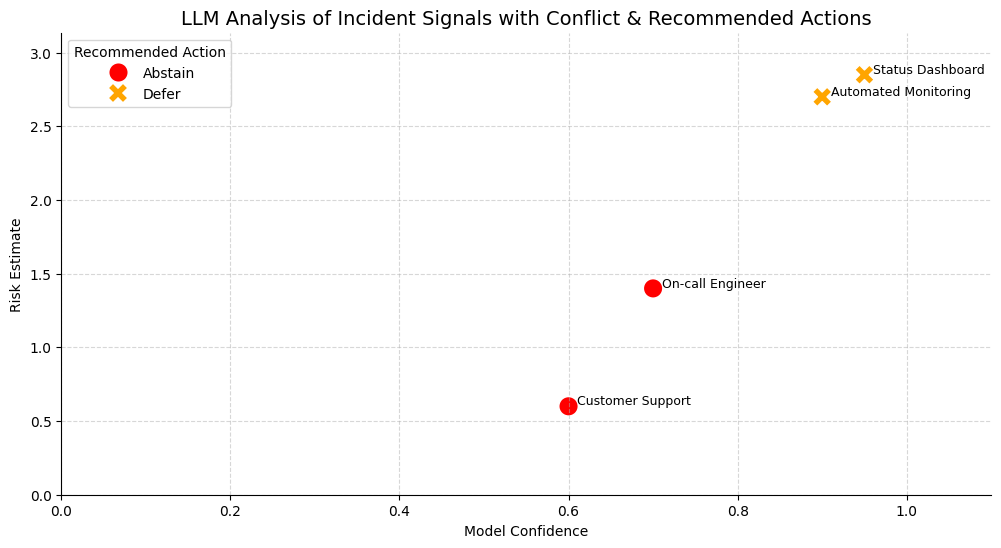

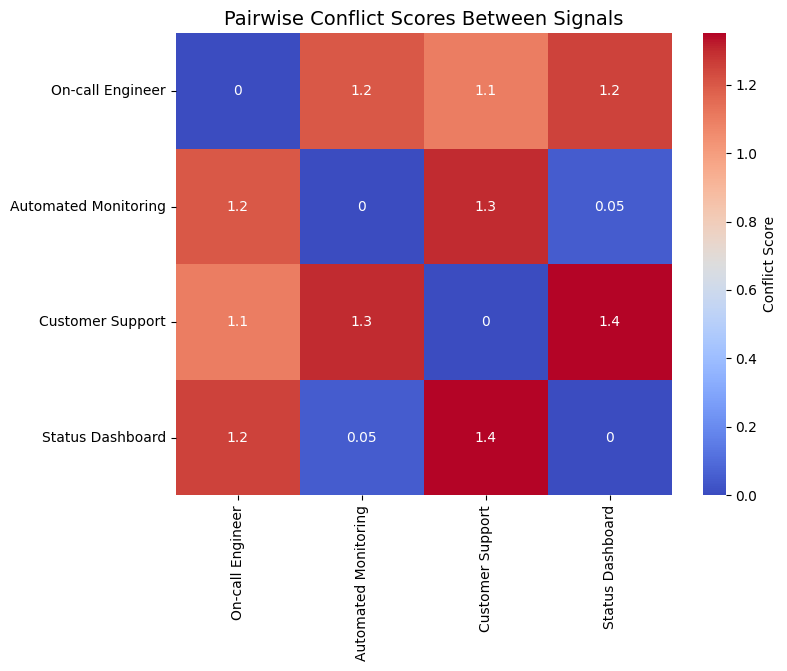

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare DataFrame for visualization
df = pd.DataFrame(action_results)

# Map recommended actions to colors
action_colors = {"Proceed": "green", "Defer": "orange", "Abstain": "red"}
df["color"] = df["recommended_action"].map(action_colors)

plt.figure(figsize=(12, 6))

# Plot risk estimate vs. model confidence
sns.scatterplot(
    data=df,
    x="model_confidence",
    y="risk_estimate",
    hue="recommended_action",
    palette=action_colors,
    s=200,
    style="recommended_action"
)

# Annotate points with signal sources
for i, row in df.iterrows():
    plt.text(
        row["model_confidence"] + 0.01,
        row["risk_estimate"] + 0.01,
        row["source"],
        fontsize=9
    )

plt.title("LLM Analysis of Incident Signals with Conflict & Recommended Actions", fontsize=14)
plt.xlabel("Model Confidence")
plt.ylabel("Risk Estimate")
plt.xlim(0, 1.1)
plt.ylim(0, max(df["risk_estimate"])*1.1)
plt.legend(title="Recommended Action")
plt.grid(True, linestyle="--", alpha=0.5)
sns.despine()

plt.show()

# Optional: visualize conflict matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conflict_matrix,
    annot=True,
    cmap="coolwarm",
    xticklabels=[s["source"] for s in llm_analysis_results],
    yticklabels=[s["source"] for s in llm_analysis_results],
    cbar_kws={"label": "Conflict Score"}
)
plt.title("Pairwise Conflict Scores Between Signals", fontsize=14)
plt.show()

- Creates a **scatter plot** showing risk vs model confidence for each signal, color-coded by recommended action  
- Annotates each signal by source for easy reference  
- Generates a **heatmap** of pairwise conflict scores to highlight disagreements  
- Provides an **intuitive, visually rich summary** for decision-makers  
- Complements numerical analysis with clear operational insights

At the end of this step, the system’s uncertainty, conflict, and action recommendations are **immediately interpretable**.

## Step 8 — Summary & Engineering Takeaways

This final step consolidates the findings and highlights the key engineering insights from the ambiguity-aware analysis.

Goals:
- Recap system behavior under conflicting or incomplete inputs  
- Highlight best practices for abstention, deferral, and human-in-the-loop design  
- Provide guidance for extending or operationalizing the framework

In [8]:
# Summarize key metrics
total_signals = len(signals)
signals_proceed = sum(1 for s in action_results if s["recommended_action"] == "Proceed")
signals_defer = sum(1 for s in action_results if s["recommended_action"] == "Defer")
signals_abstain = sum(1 for s in action_results if s["recommended_action"] == "Abstain")
signals_human_alert = len(human_alerts)

summary_metrics = {
    "Total Signals": total_signals,
    "Proceed": signals_proceed,
    "Defer": signals_defer,
    "Abstain": signals_abstain,
    "Human Alerts": signals_human_alert
}

summary_metrics

{'Total Signals': 4, 'Proceed': 0, 'Defer': 2, 'Abstain': 2, 'Human Alerts': 4}

- Provides a concise numerical summary of all signals and their recommended actions  
- Highlights how many signals required human attention, were deferred, or were safe to proceed  
- Reinforces the importance of **abstention and deferral** in ambiguous contexts  
- Serves as a **reference for engineering best practices** in operational LLM systems

This step ensures that **decision-making under ambiguity is transparent, quantifiable, and auditable**, completing the notebook’s objective.